#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


#Load and Preprocess Data

In [ ]:
# Load data
data = pd.read_csv('/content/INFOSYS.csv')
data.dropna(inplace=True)

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,VWAP
0,03-01-2000,122.070313,122.071877,122.070313,122.071877,80.904167,657536.0,122.0713557
1,04-01-2000,131.250000,131.837891,126.976563,131.686722,87.276466,7191808.0,130.1670587
2,05-01-2000,122.664063,126.953125,121.151955,121.151955,80.294495,21069440.0,123.0856783
3,06-01-2000,119.192581,119.531250,111.459763,111.459763,73.870903,10495616.0,114.1502587
4,07-01-2000,102.542969,102.542969,102.542969,102.542969,67.961205,971392.0,102.542969


In [ ]:
df = data.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1, 1))

# Split into training and testing data
training_size = int(len(df) * 0.65)
test_size = len(df) - training_size
train_data, test_data = df[0:training_size, :], df[training_size:len(df), :1]

#Create Dataset Matrix

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


#Build and Train LSTM Model

In [ ]:
# Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/100
58/58 [==============================] - 7s 36ms/step - loss: 9.0240e-04 - val_loss: 0.0034 - lr: 0.0010
Epoch 2/100
58/58 [==============================] - 1s 18ms/step - loss: 1.8283e-04 - val_loss: 0.0028 - lr: 0.0010
Epoch 3/100
58/58 [==============================] - 1s 17ms/step - loss: 1.5818e-04 - val_loss: 0.0021 - lr: 0.0010
Epoch 4/100
58/58 [==============================] - 1s 17ms/step - loss: 1.4471e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 5/100
58/58 [==============================] - 1s 17ms/step - loss: 1.3998e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 6/100
58/58 [==============================] - 1s 24ms/step - loss: 1.3944e-04 - val_loss: 8.0734e-04 - lr: 0.0010
Epoch 7/100
58/58 [==============================] - 1s 25ms/step - loss: 1.2923e-04 - val_loss: 9.8963e-04 - lr: 0.0010
Epoch 8/100
58/58 [==============================] - 1s 17ms/step - loss: 1.1401e-04 - val_loss: 7.4529e-04 - lr: 0.0010
Epoch 9/100
58/58 [==============================] -

#Make Predictions

In [ ]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE and MAE
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(ytest, test_predict))
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(ytest, test_predict)

print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')


62/62 [==============================] - 0s 6ms/step
Train RMSE: 254.21864716405528, Test RMSE: 1024.709556536852
Train MAE: 218.66033559505266, Test MAE: 924.745334913412


#Plot Predictions

In [ ]:
# Create DataFrame for plotting
df_reset = pd.DataFrame(scaler.inverse_transform(df), columns=['Value'])

# Shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
test_start_index = len(train_predict) + (look_back * 2)
test_end_index = test_start_index + len(test_predict)
testPredictPlot[test_start_index:test_end_index, :] = test_predict

# Create DataFrame for plotting
trainPredictPlot_df = pd.DataFrame(trainPredictPlot, columns=['Train Predict'])
testPredictPlot_df = pd.DataFrame(testPredictPlot, columns=['Test Predict'])

# Plot using Plotly
fig = go.Figure()

# Add train prediction trace
fig.add_trace(go.Scatter(y=trainPredictPlot_df['Train Predict'], mode='lines', name='Train Predictions'))

# Add test prediction trace
fig.add_trace(go.Scatter(y=testPredictPlot_df['Test Predict'], mode='lines', name='Test Predictions'))

# Update layout for better visualization
fig.update_layout(
    title='Train and Test Predictions',
    xaxis_title='Time',
    yaxis_title='Value',
    legend=dict(x=0, y=1, traceorder='normal'),
    margin=dict(l=40, r=40, t=40, b=40)
)

fig.show()


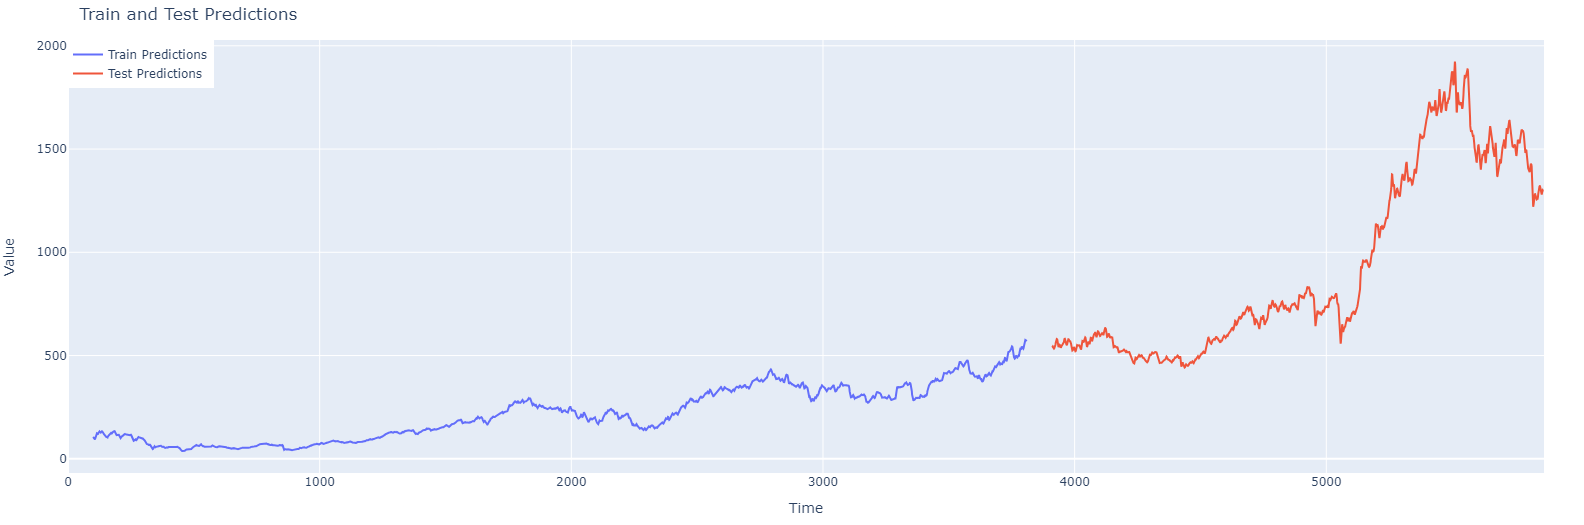

In [60]:
from PIL import Image
from IPython.display import display

# Load the image
img3 = Image.open('/content/newplot (3).png')

# Display the image
display(img3)

###Visuals from Matplot Lib

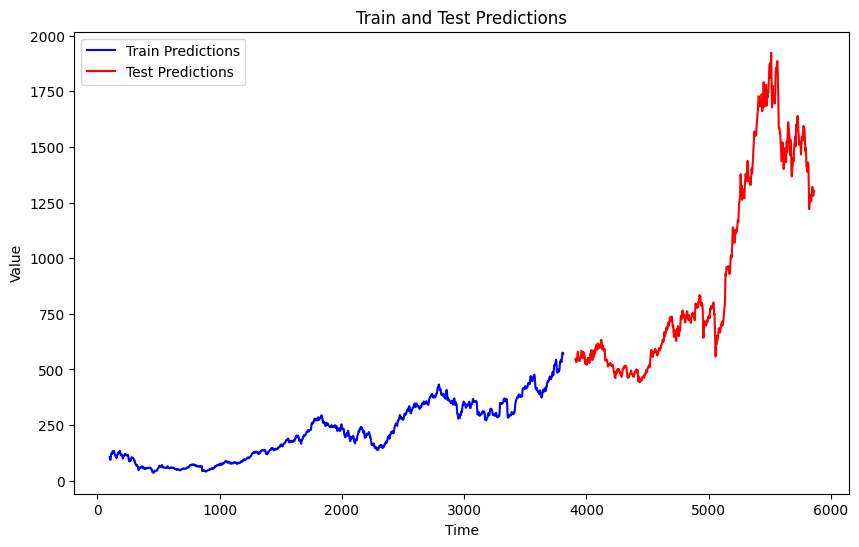

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming df, train_predict, and test_predict are already defined
# and scaler is the same used for scaling the data.

# Create DataFrame for plotting
df_reset = pd.DataFrame(scaler.inverse_transform(df), columns=['Value'])

# Shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
test_start_index = len(train_predict) + (look_back * 2)
test_end_index = test_start_index + len(test_predict)
testPredictPlot[test_start_index:test_end_index, :] = test_predict

# Create DataFrame for plotting
trainPredictPlot_df = pd.DataFrame(trainPredictPlot, columns=['Train Predict'])
testPredictPlot_df = pd.DataFrame(testPredictPlot, columns=['Test Predict'])

# Plot using Matplotlib
plt.figure(figsize=(10, 6))

# Plot train predictions
plt.plot(trainPredictPlot_df['Train Predict'], label='Train Predictions', color='blue')

# Plot test predictions
plt.plot(testPredictPlot_df['Test Predict'], label='Test Predictions', color='red')

# Update layout for better visualization
plt.title('Train and Test Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper left')

plt.show()


#Future Predictions

In [ ]:
# Future Prediction
x_input = test_data[-100:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Prepare data for plotting future predictions
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)
y_actual = scaler.inverse_transform(df[-100:]).flatten()
y_pred = scaler.inverse_transform(lst_output).flatten()

import plotly.graph_objs as go

# Create traces for actual and predicted data
trace1 = go.Scatter(
    x=day_new,
    y=y_actual,
    mode='lines',
    name='Actual Data'
)

trace2 = go.Scatter(
    x=day_pred,
    y=y_pred,
    mode='lines',
    name='Predicted Data'
)

# Create layout
layout = go.Layout(
    title='Stock Price Prediction',
    xaxis=dict(title='Days'),
    yaxis=dict(title='Stock Price'),
    legend=dict(x=0, y=1, traceorder='normal'),
    margin=dict(l=40, r=40, t=40, b=40)
)

# Create the figure and add the traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()

# For continuous plot from historical data to predictions
df2 = df.tolist()
df2.extend(lst_output)
df2 = scaler.inverse_transform(df2).flatten()

trace3 = go.Scatter(
    y=df2,
    mode='lines',
    name='Full Data (Including Predictions)'
)

# Update figure with continuous plot
fig2 = go.Figure(data=[trace3], layout=layout)
fig2.show()


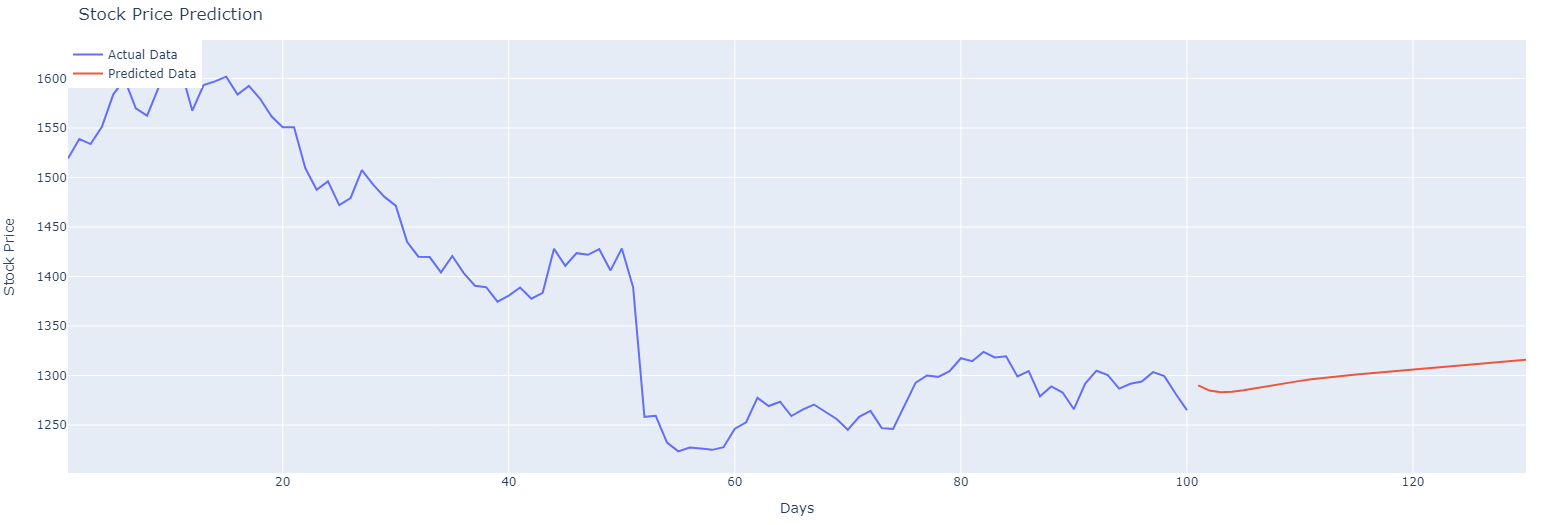

In [58]:
from PIL import Image
from IPython.display import display

# Load the image
img1 = Image.open('/content/newplot (1).png')

# Display the image
display(img1)


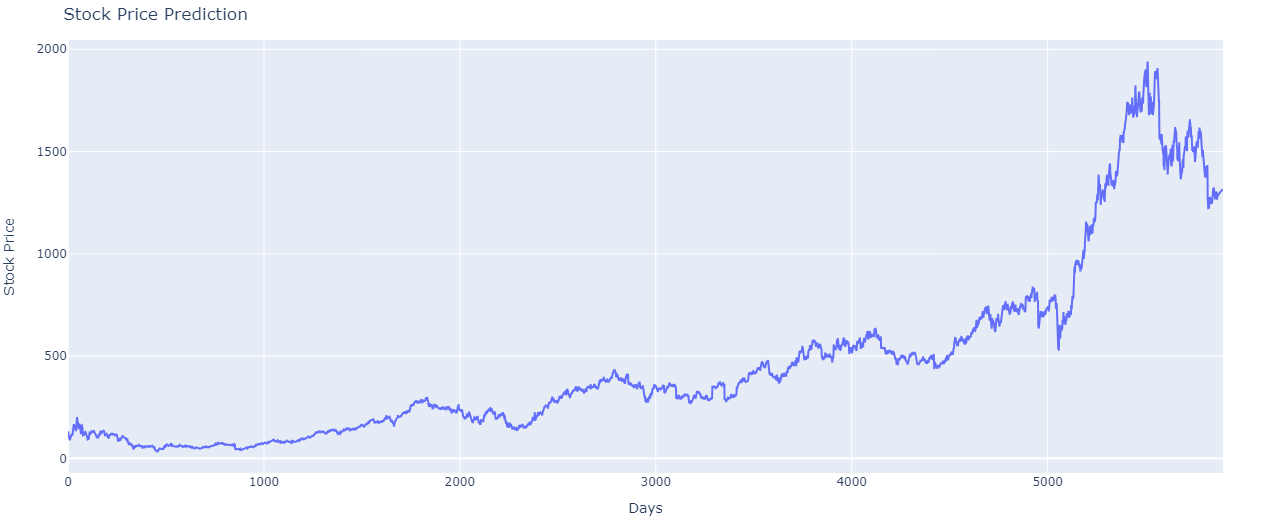

In [59]:
from PIL import Image
from IPython.display import display

# Load the image
img2 = Image.open('/content/newplot (2).png')

# Display the image
display(img2)

###Visuals from Matplot Lib

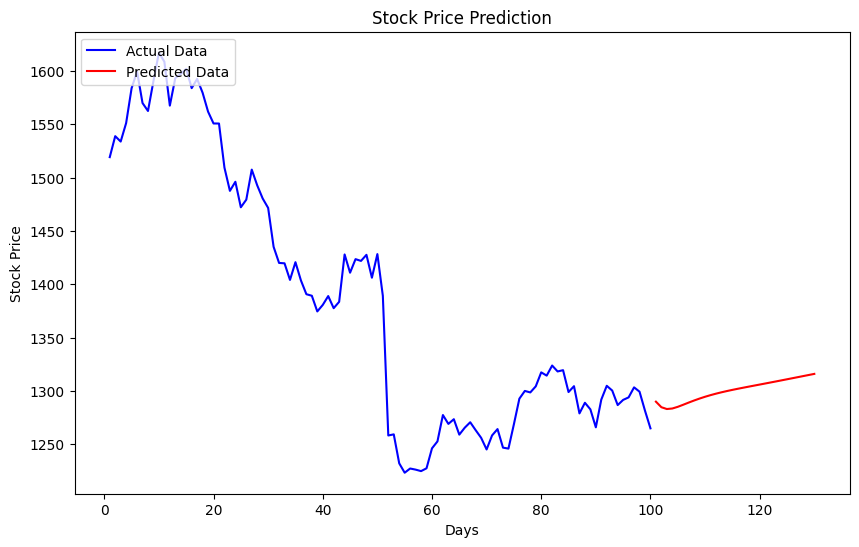

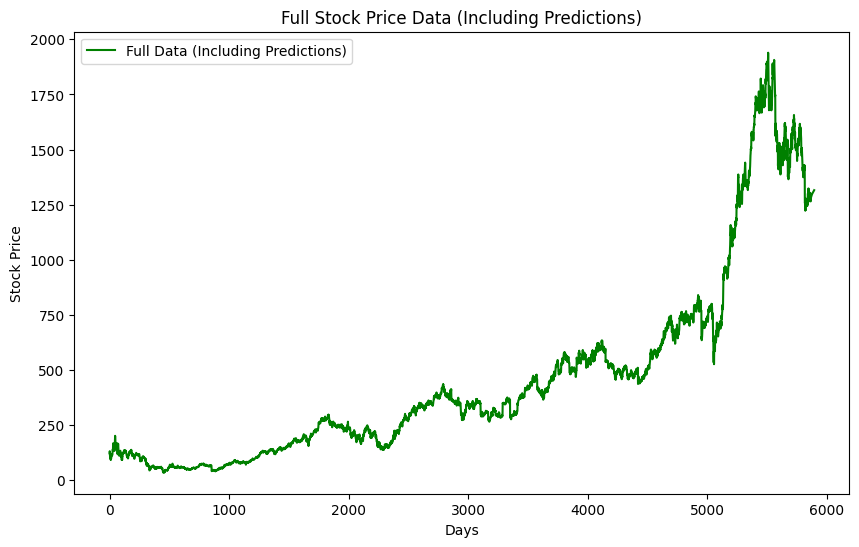

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming df, test_data, model, and scaler are already defined

# Future Prediction
x_input = test_data[-100:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Prepare data for plotting future predictions
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)
y_actual = scaler.inverse_transform(df[-100:]).flatten()
y_pred = scaler.inverse_transform(lst_output).flatten()

# Plot using Matplotlib for actual and predicted data
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(day_new, y_actual, label='Actual Data', color='blue')

# Plot predicted data
plt.plot(day_pred, y_pred, label='Predicted Data', color='red')

# Update layout for better visualization
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')

plt.show()

# For continuous plot from historical data to predictions
df2 = df.tolist()
df2.extend(lst_output)
df2 = scaler.inverse_transform(df2).flatten()

# Plot continuous data
plt.figure(figsize=(10, 6))

# Plot full data (including predictions)
plt.plot(df2, label='Full Data (Including Predictions)', color='green')

# Update layout for better visualization
plt.title('Full Stock Price Data (Including Predictions)')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')

plt.show()


#Original Data of the Future

In [ ]:
df = pd.read_csv('/content/INFY.NS.csv')

# Display the first few rows of the DataFrame
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-06-01,1322.550049,1329.500000,1318.099976,1319.500000,1278.159058,4277841
1,2023-06-02,1309.000000,1312.900024,1296.050049,1299.000000,1275.214111,10909311
2,2023-06-05,1304.000000,1309.449951,1297.300049,1304.500000,1280.613403,5002553
3,2023-06-06,1288.599976,1288.599976,1273.000000,1279.000000,1255.580322,10008100
4,2023-06-07,1290.500000,1294.000000,1282.500000,1288.949951,1265.348022,5397578


In [ ]:
import plotly.express as px
#Plot the graph using Plotly
fig_new = px.line(df, x='Date', y='Close', title='Close Price Over Time')

# Highlight the date range from June 20, 2023 to June 26, 2023
fig_new.add_vrect(
    x0='2023-06-23', x1='2023-06-26',
    fillcolor='red', opacity=0.2,
    layer='below', line_width=0,
    annotation_text='June 23, 2023 - June 26, 2023',
    annotation_position='top left'
)

# Show the plot
fig_new.show()

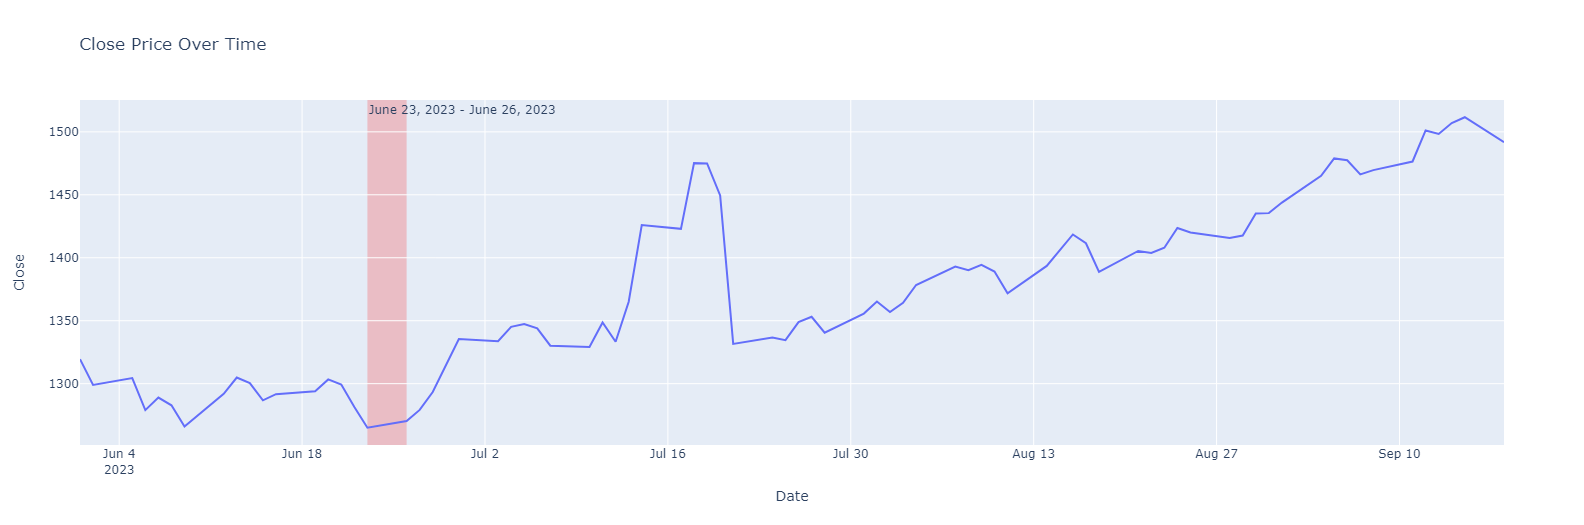

In [57]:
from PIL import Image
from IPython.display import display

# Load the image
img = Image.open('/content/newplot.png')

# Display the image
display(img)
